In [ ]:
!pip install conllu pandas matplotlib seaborn numpy

In [ ]:
import os
import glob
from conllu import parse_incr
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Path to your conllu files
UD_DIR = "/content/"

In [ ]:
dep_lengths = defaultdict(list)
dep_type_lengths = defaultdict(lambda: defaultdict(list))
sentence_stats = []

In [ ]:
for filepath in glob.glob(os.path.join(UD_DIR, "*.conllu")):
    print(f"Processing file: {filepath}")
    lang = os.path.basename(filepath).split("-")[0]
    with open(filepath, "r", encoding="utf-8") as f:
        for sent in parse_incr(f):
            token_lengths = []
            for token in sent:
                if isinstance(token["id"], int) and isinstance(token["head"], int):
                    dep_len = abs(token["id"] - token["head"])
                    token_lengths.append(dep_len)
                    dep_lengths[lang].append(dep_len)
                    dep_type = token["deprel"]
                    dep_type_lengths[lang][dep_type].append(dep_len)
            if token_lengths:
                sentence_stats.append({
                    "language": lang,
                    "sentence_length": len(sent),
                    "avg_dep_length": sum(token_lengths) / len(token_lengths),
                    "total_dep_length": sum(token_lengths)
                })

Processing file: /content/tr_tuecl-ud-test.fa.conllu
Processing file: /content/uz_tuecl-ud-test.conllu
Processing file: /content/az_tuecl-ud-test.conllu
Processing file: /content/ky_tuecl-ud-test.conllu


In [ ]:
if not sentence_stats:
    print("Warning: No sentence statistics collected. Check your file paths and data format.")
else:
    print(f"Collected {len(sentence_stats)} sentence statistics.")


Collected 550 sentence statistics.


In [ ]:
# Convert to DataFrames
df_sent = pd.DataFrame(sentence_stats)

In [ ]:
# Global summary
summary_stats = {
    lang: {
        "mean": sum(lengths)/len(lengths),
        "median": pd.Series(lengths).median(),
        "max": max(lengths),
        "std": pd.Series(lengths).std()
    }
    for lang, lengths in dep_lengths.items()
}
df_summary = pd.DataFrame(summary_stats).T

In [ ]:
print("\n=== Dependency Length Summary by Language ===")
print(df_summary.round(2))


=== Dependency Length Summary by Language ===
          mean  median   max   std
tr_tuecl  2.26     2.0  15.0  1.79
uz_tuecl  2.37     2.0  21.0  2.05
az_tuecl  2.30     2.0  16.0  1.95
ky_tuecl  2.33     2.0  18.0  2.07


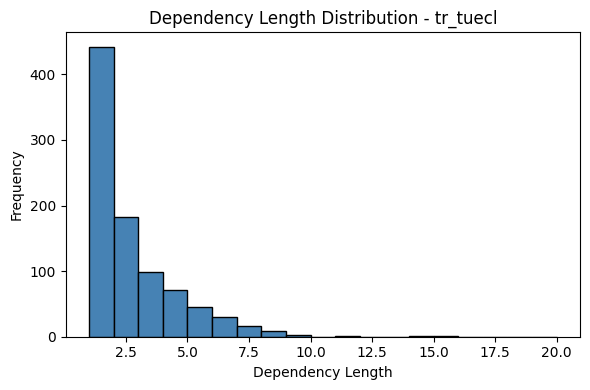

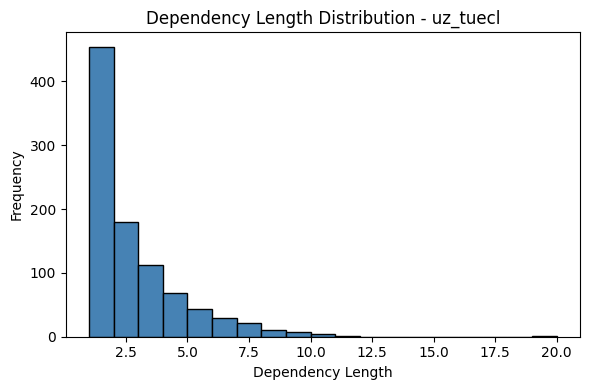

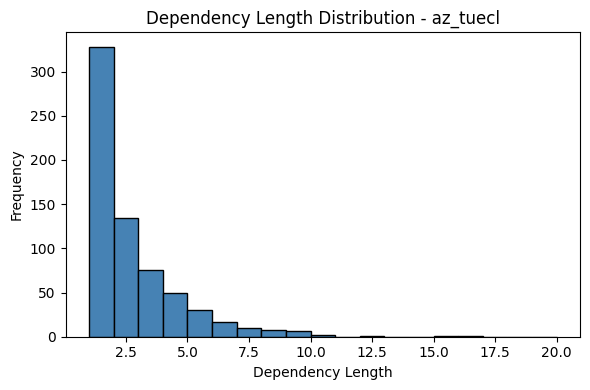

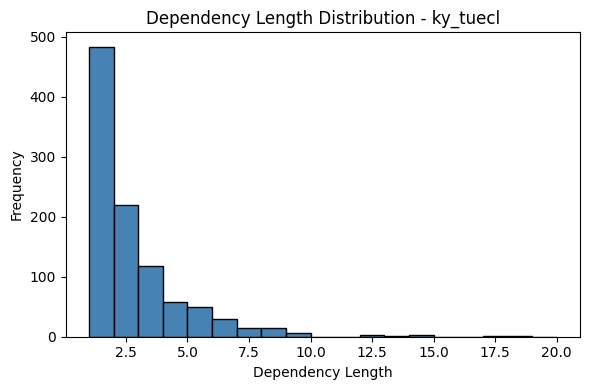

In [ ]:
# Plot 1: Histogram per language
for lang in dep_lengths:
    plt.figure(figsize=(6, 4))
    plt.hist(dep_lengths[lang], bins=range(1, 21), color="steelblue", edgecolor="black")
    plt.title(f"Dependency Length Distribution - {lang}")
    plt.xlabel("Dependency Length")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


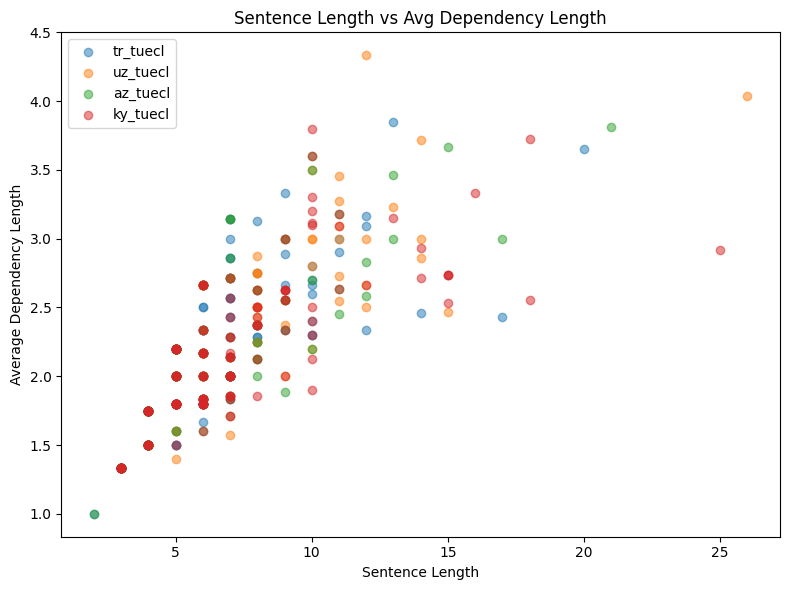

In [ ]:
# Plot 2: Avg dependency length vs sentence length
plt.figure(figsize=(8, 6))
for lang in df_sent["language"].unique():
    subset = df_sent[df_sent["language"] == lang]
    plt.scatter(subset["sentence_length"], subset["avg_dep_length"], alpha=0.5, label=lang)
plt.xlabel("Sentence Length")
plt.ylabel("Average Dependency Length")
plt.legend()
plt.title("Sentence Length vs Avg Dependency Length")
plt.tight_layout()
plt.show()

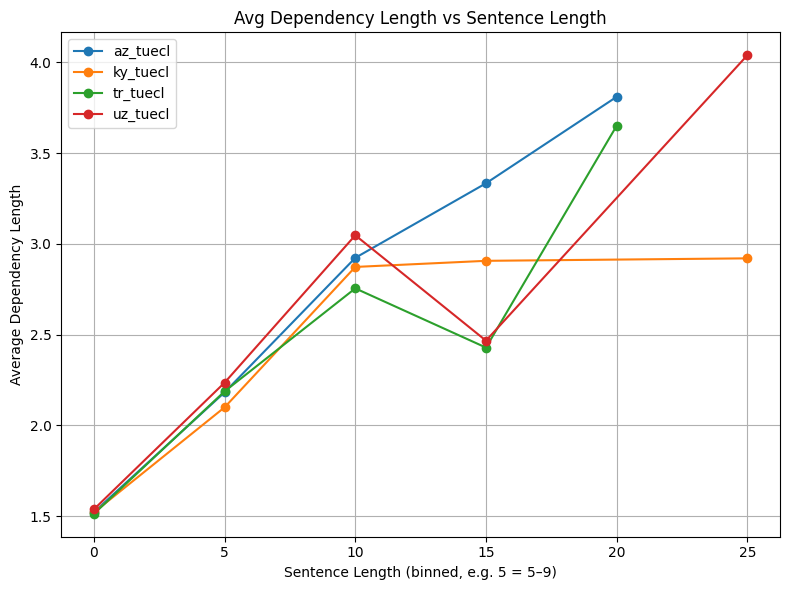

In [ ]:
import numpy as np

# Bin sentence lengths and compute average dependency length per bin
bin_size = 5
df_sent["bin"] = (df_sent["sentence_length"] // bin_size) * bin_size

# Compute mean avg_dep_length per bin per language
binned = (
    df_sent
    .groupby(["language", "bin"])["avg_dep_length"]
    .mean()
    .reset_index()
)

# Line plot
plt.figure(figsize=(8, 6))
for lang in binned["language"].unique():
    subset = binned[binned["language"] == lang]
    plt.plot(subset["bin"], subset["avg_dep_length"], marker='o', label=lang)

plt.xlabel("Sentence Length")
plt.ylabel("Average Dependency Length")
plt.title("Avg Dependency Length vs Sentence Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


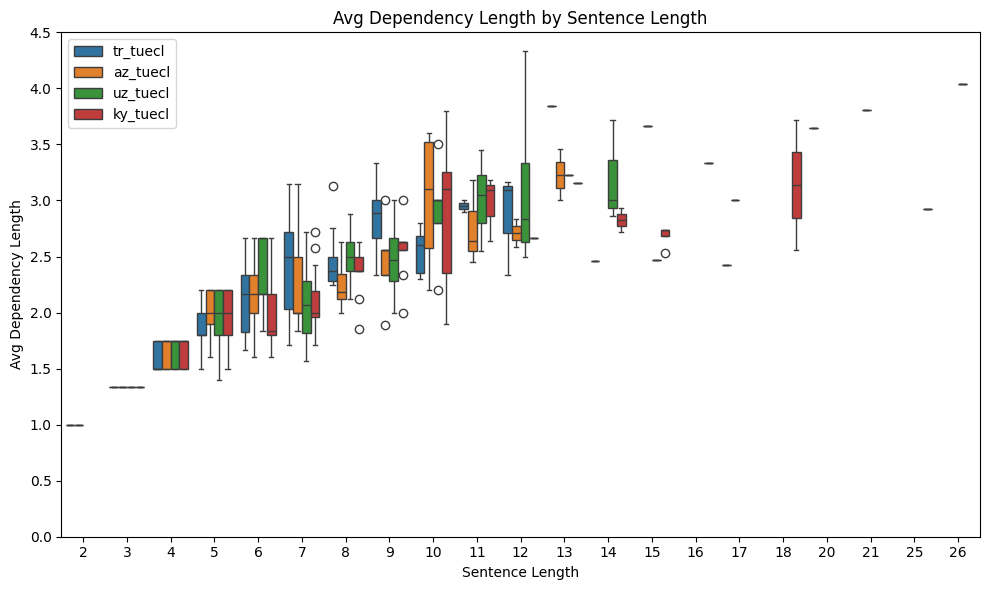

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_sent, x="sentence_length", y="avg_dep_length", hue="language")
plt.ylim(0, None)
plt.title("Avg Dependency Length by Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("Avg Dependency Length")
plt.legend()
plt.tight_layout()
plt.show()
